# AMOC Strength Evaluation
This code shows how I calculated AMOC strength in CMIP6 models through (1) integrating meridional velocity ("vo") and (2) using the model output of overturning mass streamfunction ("msftmz" or "msftyz").

The two methods show consistent results. For more information, see Lin et al. (submitted for J. Climate).

In [1]:
import warnings
warnings.filterwarnings("ignore")
import intake
import matplotlib.pyplot as plt
import numpy as np
from cmip6_preprocessing.preprocessing import combined_preprocessing

In [2]:
# This function calculates the value at specfic point of its *rightmost* coordinate. 
def AMOC_val_rightmost(x, t_val, m_val):
    dist_val  = np.abs(m_val - t_val)
    id_val    = np.argsort(dist_val)
    slice0    = x[...,id_val[0]]
    slice1    = x[...,id_val[1]]
    slice_val = (slice0 * dist_val[id_val[1]] + slice1 * dist_val[id_val[0]]) / (dist_val[id_val[0]]+dist_val[id_val[1]])    
    return slice_val

def tic():
    import time
    global startTime_for_tictoc
    startTime_for_tictoc = time.time()
def toc():
    import time
    if 'startTime_for_tictoc' in globals():
        print("Elapsed time is " + str(time.time() - startTime_for_tictoc) + " seconds.")
    else:
        print("Toc: start time not set")
        
# Constants
r_earth = 6.371*1e6
mon_wgt = np.array([31., 28., 31., 30., 31., 30., 31., 31., 30., 31., 30., 31.])

## (1) AMOC strength from integrating meridional velocity ("vo")

In [3]:
im         = "CESM2"
iv         = "vo"
ie_ls      = ["piControl", "abrupt-4xCO2"]
ny         = 150
nt         = ny*12

In [4]:
# ADD THE BOUNDARY INFORMATION HERE #
# 35N: 90W-0, 0-45E
# 26.5N: 102W-5W
WB = {}
EB = {}
WB['35.0'] = 270.
EB['35.0'] = 45. # include mediterranean sea
# EB['35.0'] = 355. # exclude mediterranean sea

WB['26.5'] = 258.
EB['26.5'] = 355.

# CHOOSE YOUR TARGET LATITUDE HERE #
lat_target = 35.
# lat_target = 26.5

In [5]:
url = "https://storage.googleapis.com/cmip6/pangeo-cmip6.json"
col = intake.open_esm_datastore(url)

##### This below cell holds the main code for integration, which is also the most time-consuming process (~46 mins for CESM2). 

In [6]:
msft_vo = {}
for ie in ie_ls:
    cat = col.search(
        source_id=im,
        experiment_id=ie,
        table_id="Omon",
        variable_id=iv,
        member_id="r1i1p1f1",
    )
    
    dset_dict = cat.to_dataset_dict(
    zarr_kwargs={"consolidated": True, "decode_times": True, "use_cftime": True}, preprocess=combined_preprocessing
    )    
    print(dset_dict.keys())
    if len(dset_dict.keys())>1:
        print("Warning. More than one file.")
    ds = dset_dict[list(dset_dict.keys())[0]]
    
    print('====================== Coords info ======================')
    # Some modele do not give the right order of coords, so "transpose" yourself.
    m_lon = ds.coords['lon'].transpose("y", "x")
    m_lat = ds.coords['lat'].transpose("y", "x")
    m_lev = ds.coords['lev']
    m_lon_bnds = ds.coords['lon_bounds'].transpose("bnds", "y", "x")
    m_lev_bnds = ds.coords['lev_bounds'].transpose("lev", "bnds")

    m_lon_val = m_lon.values
    m_lat_val = m_lat.values
    m_lon_nan = np.where(abs(m_lon_val)>1000.,np.nan,m_lon_val)
    m_lat_nan = np.where(abs(m_lat_val)>1000.,np.nan,m_lat_val)
    m_lon_new = m_lon_nan.copy()
    m_lat_new = m_lat_nan.copy()
    
    xlen = m_lon_new.shape[1]
    ylen = m_lon_new.shape[0]
    
    dz       = m_lev_bnds[:,1] - m_lev_bnds[:,0]
    dz_val   = dz.values

    m_lon_bnds_val = m_lon_bnds.values
    m_lev_val      = m_lev.values

    print('====================== Find the western and eastern boundaries ======================')
    dist_WB  = np.abs(m_lon_new - WB[str(lat_target)])
    dist_EB  = np.abs(m_lon_new - EB[str(lat_target)])
    dist_lat = np.abs(m_lat_new - lat_target)
    dist_WB2 = dist_WB + dist_lat 
    dist_EB2 = dist_EB + dist_lat 
    id_WB    = np.unravel_index(np.argsort(dist_WB2, axis=None), dist_WB2.shape)
    xid_WB   = id_WB[1][0]
    yid_WB   = id_WB[0][0]
    id_EB    = np.unravel_index(np.argsort(dist_EB2, axis=None), dist_EB2.shape)
    xid_EB   = id_EB[1][0]
    yid_EB   = id_EB[0][0]
    print("Check if you get the western boundary right: m_lon="+str(m_lon_new[yid_WB,xid_WB]))
    print("Check if you get the western boundary right: m_lat="+str(m_lat_new[yid_WB,xid_WB]))
    print("Check if you get the eastern boundary right: m_lon="+str(m_lon_new[yid_EB,xid_EB]))
    print("Check if you get the eastern boundary right: m_lat="+str(m_lat_new[yid_EB,xid_EB]))

    if xid_WB > xid_EB:
        print('Concatenate two parts of Atlantic Basin')
        xid_arr = np.concatenate((np.arange(0,xid_EB+1,1), np.arange(xid_WB,xlen,1)))
    if xid_WB < xid_EB:
        print('Continuous longitude in Atlantic Basin')
        xid_arr = np.arange(xid_WB,xid_EB+1,1)

    print('====================== Calculating streamfunction in the Atlantic Ocean ======================')    
    slice_sumz = np.full((nt,len(m_lev),xlen), np.nan)

    tic()
    for it in range(nt):
        if (it+1)%100==0:
            print('Completing...'+str(it+1)+' out of 1800 timesteps.')

        ds_val = ds[iv].isel(time=it).squeeze().transpose("lev", "y", "x").values
 
        for ix in xid_arr:
            dist_lat = np.abs(m_lat_new[:,ix] - lat_target)
            id_lat   = np.argsort(dist_lat)
            if dist_lat[id_lat[0]] < 1e-3:
                slice_ = ds_val[...,id_lat[0],ix]
            else:
                slice0 = ds_val[...,id_lat[0],ix]
                slice1 = ds_val[...,id_lat[1],ix]
                slice_ = (slice0 * dist_lat[id_lat[1]] + slice1 * dist_lat[id_lat[0]]) / (dist_lat[id_lat[0]]+dist_lat[id_lat[1]])

            dlon = m_lon_bnds_val[1,id_lat[0],ix] - m_lon_bnds_val[0,id_lat[0],ix]

            if np.abs(dlon) > 10.:
                # print('Unrealistic dlon:'+str(dlon)+'. Must happen in the boundary.')
                if ix == xid_arr[0]:
                    # print('The first xid_arr is at the longitude of 0/360.')
                    # print('Use the eastern boundary dlon. dlon:'+str(dlon))
                    # since dlon is unrealistic only because it is on the longitude of 0/360, and the fact that "eastern boundary" of the Atlantic is close to the longitude of 0/360
                    # we set the default dlon on the eastern boundary
                    # this is only necessary for the model whose first xid_arr is 0/360 ... (for now, only INM-CM4-8 & CAS-ESM2-0 need this)
                    dlon = m_lon_bnds_val[1,yid_EB,xid_EB] - m_lon_bnds_val[0,yid_EB,xid_EB]                    
                else:
                    # print('Use the previous realistic dlon. dlon:'+str(dlon))
                    dlon = m_lon_bnds_val[1,id_lat[0],ix_copy] - m_lon_bnds_val[0,id_lat[0],ix_copy]
            else:
                ix_copy  = ix.copy() # this saves the previous realistic value of ix 

            dx        = r_earth*np.cos(np.deg2rad(lat_target))*np.deg2rad(dlon)
            slice_dz  = slice_*dz_val*np.abs(dx)
 
            for il in range(len(m_lev)):
                slice_sumz[it,il,ix] = -np.nansum(slice_dz[il:]) / 1e6
      
    msft_vo[ie] = np.nansum(slice_sumz,axis=2)
    toc()    


--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'


dict_keys(['CMIP.NCAR.CESM2.piControl.Omon.gn'])
====================== Coords info ======================
====================== Find the western and eastern boundaries ======================
Check if you get the western boundary right: m_lon=269.9410339473835
Check if you get the western boundary right: m_lat=34.83378953012475
Check if you get the eastern boundary right: m_lon=44.82028574781257
Check if you get the eastern boundary right: m_lat=34.921469633592196
Concatenate two parts of Atlantic Basin
====================== Calculating streamfunction in the Atlantic Ocean ======================
Completing...100 out of 1800 timesteps.
Completing...200 out of 1800 timesteps.
Completing...300 out of 1800 timesteps.
Completing...400 out of 1800 timesteps.
Completing...500 out of 1800 timesteps.
Completing...600 out of 1800 timesteps.
Completing...700 out of 1800 timesteps.
Completing...800 out of 1800 timesteps.
Completing...900 out of 1800 timesteps.
Completing...1000 out of 1800 times

dict_keys(['CMIP.NCAR.CESM2.abrupt-4xCO2.Omon.gn'])
====================== Coords info ======================
====================== Find the western and eastern boundaries ======================
Check if you get the western boundary right: m_lon=269.9410339473835
Check if you get the western boundary right: m_lat=34.83378953012475
Check if you get the eastern boundary right: m_lon=44.82028574781257
Check if you get the eastern boundary right: m_lat=34.921469633592196
Concatenate two parts of Atlantic Basin
====================== Calculating streamfunction in the Atlantic Ocean ======================
Completing...100 out of 1800 timesteps.
Completing...200 out of 1800 timesteps.
Completing...300 out of 1800 timesteps.
Completing...400 out of 1800 timesteps.
Completing...500 out of 1800 timesteps.
Completing...600 out of 1800 timesteps.
Completing...700 out of 1800 timesteps.
Completing...800 out of 1800 timesteps.
Completing...900 out of 1800 timesteps.
Completing...1000 out of 1800 ti

## (2) AMOC strength from ocean mass streamfunction (model output)
- Basin name could be different among models ('baisn', 'sector', '3basin', ...)
- Basin information in FGOALS models seem to be wrong. 0: Global 1:Atlantic. 

In [7]:
iv         = "msftmz" # "msftmz", "msftyz"
basin_name = "basin" # "basin", "sector", "3basin". ..
lat_name   = "lat" # "lat", "rlat", "nav_lat", "y"
lev_name   = "lev" # "lev", "olevel"

In [8]:
msft_out = {}
for ie in ie_ls:
    cat = col.search(
        source_id=im,
        experiment_id=ie,
        table_id="Omon",
        variable_id=iv,
        member_id="r1i1p1f1",
    )
    
    dset_dict = cat.to_dataset_dict(
    zarr_kwargs={"consolidated": True, "decode_times": True, "use_cftime": True}
    )    
    print(dset_dict.keys())
    if len(dset_dict.keys())>1:
        print("Warning. More than one file.")
    ds = dset_dict[list(dset_dict.keys())[0]]
    
    # msft in Atlantic Ocean
    print(ds.coords[basin_name])
    ATARO_id   = int(input('Which one is Atlantic-Artic Ocean? (Start with 0)'))
    ds_AT      = ds[iv].isel(time=range(0,nt,1), basin=ATARO_id)
    
    # latitude and level values
    m_lat = ds_AT.coords[lat_name]
    if ds[lev_name].values[-1] > 8000:
        print('=== Warning. Z-axis is not in meters. ===')
        print('=== Warning. The deepest point is at: '+str(ds['lev'].values[-1])+'. ===')
        print('=== Warning. It is in '+ds.coords['lev'].attrs['units']+'. ===')
        print('=== Warning. Error occurs when it is not in cm. ===')
        m_lev = ds[lev_name].values/100.
    
    # msft value at latitude of 35N and depth of 1000m
    ds_AT_35N    = AMOC_val_rightmost(ds_AT, 35.0, m_lat)
    ds_AT_35N_1K = AMOC_val_rightmost(ds_AT_35N, 1000.0, m_lev)
    
    # annual mean; for plots
    msft_mon     = ds_AT_35N_1K.squeeze().values/1e9
    msft_ann     = np.average(msft_mon.reshape(ny,12), axis=1, weights=mon_wgt)
    msft_out[ie] = msft_ann.copy()


--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'


dict_keys(['CMIP.NCAR.CESM2.piControl.Omon.gn'])
<xarray.DataArray 'basin' (basin: 3)>
array([0, 1, 2], dtype=int32)
Coordinates:
  * basin    (basin) int32 0 1 2
Attributes:
    coords:         region
    requested:      atlantic_arctic_ocean=0, indian_pacific_ocean=1, global_o...
    standard_name:  region
    title:          ocean basin
    type:           int
    units:          1


Which one is Atlantic-Artic Ocean? (Start with 0) 0


=== Warning. Z-axis is not in meters. ===
=== Warning. The deepest point is at: 549999.0625. ===
=== Warning. It is in centimeters. ===
=== Warning. Error occurs when it is not in cm. ===

--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'


dict_keys(['CMIP.NCAR.CESM2.abrupt-4xCO2.Omon.gn'])
<xarray.DataArray 'basin' (basin: 3)>
array([0, 1, 2], dtype=int32)
Coordinates:
  * basin    (basin) int32 0 1 2
Attributes:
    coords:         region
    requested:      atlantic_arctic_ocean=0, indian_pacific_ocean=1, global_o...
    standard_name:  region
    title:          ocean basin
    type:           int
    units:          1


Which one is Atlantic-Artic Ocean? (Start with 0) 0


=== Warning. Z-axis is not in meters. ===
=== Warning. The deepest point is at: 549999.0625. ===
=== Warning. It is in centimeters. ===
=== Warning. Error occurs when it is not in cm. ===


Text(0, 0.5, 'AMOC strength (Sv)')

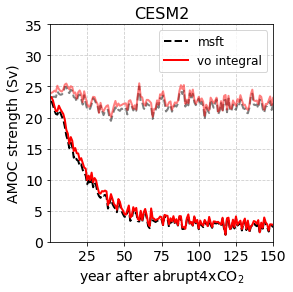

In [9]:
plt.figure(figsize=(4,4))
plt.plot(np.arange(1,151,1),msft_out['piControl'],'--',color=(0,0,0,0.5),linewidth=2)
plt.plot(np.arange(1,151,1),msft_out['abrupt-4xCO2'],'--',color=(0,0,0,1),linewidth=2,label='msft')
plt.plot(np.arange(1,151,1),np.average(AMOC_val_rightmost(msft_vo['piControl'], 1000.0, m_lev).reshape(ny,12), axis=1, weights=mon_wgt),color=(1,0,0,0.5),linewidth=2)
plt.plot(np.arange(1,151,1),np.average(AMOC_val_rightmost(msft_vo['abrupt-4xCO2'], 1000.0, m_lev).reshape(ny,12), axis=1, weights=mon_wgt),color=(1,0,0,1),linewidth=2,label='vo integral')
plt.legend(fontsize=12)
plt.title(im,fontsize=16)   
plt.grid(color=(0.8,0.8,0.8,1),linestyle='--')
plt.yticks(np.arange(0,36,5),fontsize=14)
plt.xticks(np.array((25,50,75,100,125,150)),fontsize=14)
plt.axis([0,150,0,35])
plt.xlabel('year after abrupt4xCO$_{2}$',fontsize=14)
plt.ylabel('AMOC strength (Sv)',fontsize=14)

The figure shows the AMOC strength at 35N and 1000m in 150-year abrupt-4xCO2 and corresponding piControl simulations in CESM2, which is a reproduction as in Figure A1 (CESM2 part) in Lin et al. (submitted for J. Climate).

## Acknowledgment: 

Pangeo cloud-based datasets (Abernathey et al. 2021*) and the package xMIP (formerly cmip6_preprocessing; [![DOI](https://zenodo.org/badge/DOI/10.5281/zenodo.6812409.svg)](https://doi.org/10.5281/zenodo.6812409)) were used to access and postprocess the model output.

*R. P. Abernathey et al., "Cloud-Native Repositories for Big Scientific Data," in Computing in Science & Engineering, vol. 23, no. 2, pp. 26-35, 1 March-April 2021, doi: 10.1109/MCSE.2021.3059437.